In [2]:
import pandas as pd
import os

# Path to the data folder
DATA_PATH = '../data/'

# List all downloaded CSVs
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

# Dictionary to store factor data
factor_data = {}

# Debug: check column names of a sample file
sample_df = pd.read_csv(f"{DATA_PATH}AAPL.csv", index_col=0)
print(sample_df.columns)

for ticker in tickers:
    print(f"Processing {ticker}...")
    
    # Load the data
    df = pd.read_csv(f"{DATA_PATH}{ticker}.csv")
    df = df[['Close']]  # Use close for factor calculations
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    
    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change(fill_method=None)
    
    # 1. Momentum: past 12-month return (excluding last month)
    df['Momentum'] = df['Close'].pct_change(252).shift(-21)
    
    # 2. Volatility: standard deviation of daily returns over 60 days
    df['Volatility'] = df['Returns'].rolling(window=60).std()
    
    # 3. SMA ratio: current price / 200-day SMA
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['SMA_Ratio'] = df['Close'] / df['SMA_200']
    
    # Drop rows with NaNs
    df.dropna(inplace=True)
    
    # Save to dictionary
    factor_data[ticker] = df

print("✅ Factor calculation complete.")


Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Processing AAPL...
Processing MSFT...
Processing GOOGL...
Processing AMZN...
Processing META...
✅ Factor calculation complete.


In [3]:
import pandas as pd

# Combine all tickers' data into one DataFrame
all_factors = []

for ticker, df in factor_data.items():
    df = df.copy()
    df['Ticker'] = ticker
    
    # ✅ Include Returns in the selected columns
    df = df[['Returns', 'Momentum', 'Volatility', 'SMA_Ratio', 'Ticker']]
    all_factors.append(df)

# Combine into a single DataFrame
combined_df = pd.concat(all_factors)
combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index': 'Date'}, inplace=True)

# Drop rows with any missing factor values
combined_df.dropna(subset=['Returns', 'Momentum', 'Volatility', 'SMA_Ratio'], inplace=True)

# Standardize each factor by date (cross-sectional z-score)
for factor in ['Momentum', 'Volatility', 'SMA_Ratio']:
    combined_df[f'{factor}_z'] = combined_df.groupby('Date')[factor].transform(
        lambda x: (x - x.mean()) / x.std(ddof=0)
    )

# Composite score: simple average of z-scores
combined_df['Composite_Score'] = combined_df[['Momentum_z', 'Volatility_z', 'SMA_Ratio_z']].mean(axis=1)

# Optional: Sort by date and composite score (descending)
combined_df.sort_values(by=['Date', 'Composite_Score'], ascending=[True, False], inplace=True)

# ✅ Final output used for portfolio visualization
df_factors = combined_df

# Preview result
print(df_factors.head(10))


      Date   Returns  Momentum  Volatility  SMA_Ratio Ticker  Momentum_z  \
4524   233  0.009919  0.261789    0.030151   0.995736   AMZN    1.394870   
1508   233  0.006353  0.152835    0.020499   1.090349   MSFT    0.842150   
3016   233  0.013768 -0.044483    0.019918   0.982155  GOOGL   -0.158832   
0      233 -0.005402 -0.162169    0.022303   0.924075   AAPL   -0.755845   
6032   233  0.013917 -0.273840    0.020815   0.813430   META   -1.322343   
4525   234  0.048628  0.308246    0.030850   1.043163   AMZN    1.380547   
1509   234  0.010821  0.200863    0.020528   1.100999   MSFT    0.859902   
3017   234  0.006047 -0.012322    0.019928   0.988003  GOOGL   -0.173728   
1      234  0.034942 -0.126251    0.022835   0.956012   AAPL   -0.726109   
6033   234  0.003414 -0.252992    0.020816   0.817064   META   -1.340613   

      Volatility_z  SMA_Ratio_z  Composite_Score  
4524      1.956360     0.379526         1.243586  
1508     -0.590464     1.417716         0.556468  
3016     -

In [4]:
grouped = df_factors.groupby('Date')
portfolio_returns = []

for date, group in grouped:
    group = group.dropna(subset=['Composite_Score', 'Returns'])
    
    top = group.nlargest(2, 'Composite_Score')
    bottom = group.nsmallest(2, 'Composite_Score')
    
    long_return = top['Returns'].mean()
    short_return = bottom['Returns'].mean()
    
    daily_return = long_return - short_return
    portfolio_returns.append({'Date': date, 'Portfolio_Return': daily_return})

portfolio_df = pd.DataFrame(portfolio_returns)
portfolio_df['Date'] = pd.to_datetime(portfolio_df['Date'], unit='D', origin='1970-01-01')
portfolio_df.set_index('Date', inplace=True)

portfolio_df['Cumulative_Return'] = (1 + portfolio_df['Portfolio_Return']).cumprod()

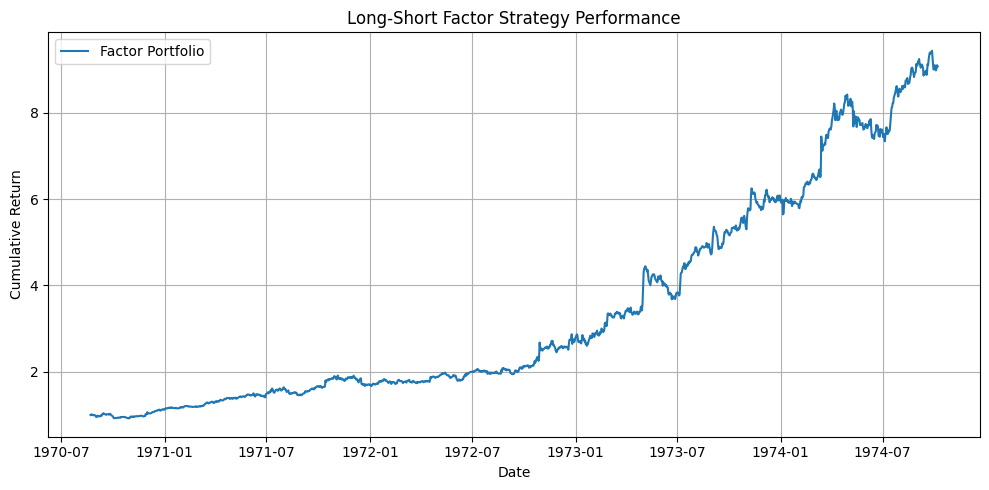

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(portfolio_df['Cumulative_Return'], label='Factor Portfolio')
plt.title('Long-Short Factor Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
import os

# Create directory if it doesn't exist
output_dir = '../data/factor_csvs'
os.makedirs(output_dir, exist_ok=True)

# Save per-ticker CSV
for ticker in df_factors['Ticker'].unique():
    df_ticker = df_factors[df_factors['Ticker'] == ticker].copy()
    df_ticker.sort_values(by='Date', inplace=True)
    df_ticker.to_csv(f'{output_dir}/{ticker}.csv', index=False)